<a href="https://colab.research.google.com/github/LevPerla/Deep_Learning_school/blob/master/homework_neural_networks_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg"  width=400></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

# Домашнее задание. Обучение нейронных сетей на PyTorch.

В этом домашнем задании вам предстоит предсказывать типы небесных объектов. Эту задачу вы будете решать с помощью нейронных сетей, используя библиотеку PyTorch. 

Вам необходимо заполнить пропуски в ноутбуке. Кое-где вас просят сделать выводы о проделанной работе. Постарайтесь ответить на вопросы обдуманно и развёрнуто. 


***В этом домашнем задании мы используем новый метод проверки --- Peer Review.***

Peer Review — альтернативный способ проверки ваших заданий, который подразумевает, что после сдачи задания у вас появится возможность (и даже моральная обязанность, но не строгое обязательство) проверить задания нескольких ваших однокурсников. Соответственно, и ваши работы будут проверять другие учащиеся курса. Для выставления оценки необходимо будет, чтобы вашу работу проверило по крайней мере 3 ваших однокурсника. Вы же, выступая в роли проверяющего, сможете узнать больше о выполненном задании, увидеть, как его выполняли другие. 

Чем больше заданий однокурсников вы проверите, тем лучше! Но, пожалуйста, проверяйте внимательно. По нашим оценкам, на проверку одной работы у вас уйдёт 5-10 минут. Подробные инструкции для проверки заданий мы пришлём позже.

***ВАЖНО!*** Чтобы задание было удобнее проверять, необходимо сдать на Stepik два файла: файл в формате .ipynb и файл в формате .pdf. Файл .pdf можно получить, открыв File->Print и выбрать "Save as PDF". Аналогичный способ есть и в Jupyter.


In [0]:
import torch
from torch import nn
from torch import functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Дисклеймер про CrossEntropyLoss и NLLLoss

Обычно в PyTorch не нужно делать Softmax как последний слой модели. 

* Если Вы используете NLLLoss, то ему на вход надо давать лог вероятности, то есть выход слоя LogSoftmax. (Просто результат софтмакса, к которому применен логарифм)
* Если Вы используете CrossEntropyLoss, то применение LogSoftmax уже включено внутрь лосса, поэтому ему на вход надо подавать просто выход обычного линейного слоя без активации. По сути CrossEntropyLoss = LogSoftmax + NLLLoss

Зачем такие сложности, чтобы посчитать обычную кросс энтропию, которую мы использовали как лосс еще в логистической регрессии? Дело в том, что нам в любом случае придется взять логарифм от результатов софтмакса, а если делать это одной функцией, то можно сделать более устойчивую реализацию, которая даст меньшую вычислительную погрешность. 

Таким образом, если у вас в конце сети, решающей задачу классификации, стоит просто линейный слой без активации, то вам нужно использовать CrossEntropy. В этой домашке везде используется лосс CrossEntropy

# Задание 1. Создайте генератор батчей. 

В этот раз мы хотим сделать генератор, который будет максимально похож на то, что используется в реальном обучении. 

С помощью numpy вам нужно перемешать исходную выборку и выбирать из нее батчи размером batch_size, если размер выборки не делился на размер батча, то последний батч должен иметь размер меньше batch_size и состоять просто из всех оставшихся объектов. Возвращать нужно в формате (X_batch, y_batch). Необходимо написать именно генератор, то есть вместо return использовать yield. 

Хорошая статья про генераторы: https://habr.com/ru/post/132554/


**Ответ на задание - код**


In [0]:
def batch_generator(X, y, batch_size):
    num_samples = X.shape[0]

    # set seed
    np.random.seed(42)
    
    # mix samples
    perm = np.random.permutation(num_samples)
    X = X[perm]
    y = y[perm]

    num_butches = num_samples // batch_size

    for i in range(num_butches):
      yield X[i * batch_size : (i + 1) * batch_size],\
            y[i * batch_size : (i + 1) * batch_size]
    
    tail = num_samples % batch_size
    if tail != 0:
      yield X[-tail:], y[-tail:]

Попробуем потестировать наш код

In [0]:
from inspect import isgeneratorfunction
assert isgeneratorfunction(batch_generator), "batch_generator должен быть генератором! В условии есть ссылка на доки"

X = np.array([
              [1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]
])
y = np.array([
              1, 2, 3
])

# Проверим shape первого батча
iterator = batch_generator(X, y, 2)
X_batch, y_batch = next(iterator)
assert X_batch.shape == (2, 3), y_batch.shape == (2,)
assert np.allclose(X_batch, X[:2]), np.allclose(y_batch, y[:2])

# Проверим shape последнего батча (их всего два)
X_batch, y_batch = next(iterator)
assert X_batch.shape == (1, 3), y_batch.shape == (1,)
assert np.allclose(X_batch, X[2:]), np.allclose(y_batch, y[2:])

# Проверим, что итерации закончились
iter_ended = False
try:
    next(iterator)
except StopIteration:
    iter_ended = True
assert iter_ended

# Еще раз проверим то, сколько батчей создает итератор
X = np.random.randint(0, 100, size=(1000, 100))
y = np.random.randint(-1, 1, size=(1000, 1))
num_iter = 0
for _ in batch_generator(X, y, 3):
    num_iter += 1
assert num_iter == (1000 // 3 + 1)

# Задание 2. Обучите модель для классификации звезд

Загрузите датасет из файла sky_data.csv, разделите его на train/test и обучите на нем нейронную сеть (архитектура ниже). Обучайте на батчах с помощью оптимизатора Adam, lr подберите сами, пробуйте что-то вроде 1e-2

Архитектура:

1. Dense Layer с relu активацией и 50 нейронами
2. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте 50%) 
3. BatchNorm
4. Dense Layer с relu активацией и 100 нейронами
5. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте для разнообразия 50%)
6. BatchNorm
7. Выходной Dense слой c количеством нейронов, равному количеству классов

Лосс - CrossEntropy.

В датасете классы представлены строками, поэтому классы нужно закодировать. Для этого в строчке ниже объявлен dict, с помощью него и функции map превратите столбец с таргетом в целое число. Кроме того, за вас мы выделили признаки, которые нужно использовать.

### Загрузка и обработка данных

In [0]:
feature_columns = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field']
target_column = 'class'

target_mapping = {
    'GALAXY': 0,
    'STAR': 1,
    'QSO': 2
}

In [249]:
data = pd.read_csv('https://drive.google.com/uc?id=1K-8CtATw6Sv7k2dXco1fL5MAhTbKtIH3')
data['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

In [250]:
data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [0]:
# Extract Features
X = data[feature_columns]
# Extract target
y = data[target_column]

# encode target with target_mapping
y = y.map(target_mapping).values

Нормализация фичей

In [0]:
# Просто вычтите среднее и поделитe на стандартное отклонение (с помощью пандас). Также преобразуйте всё в np.array
X = ((X - X.mean()) / X.std(ddof=0)).values

In [0]:
assert type(X) == np.ndarray and type(y) == np.ndarray, 'Проверьте, что получившиеся массивы являются np.ndarray'
assert np.allclose(y[:5], [1,1,0,1,1])
assert X.shape == (10000, 10)
assert np.allclose(X.mean(axis=0), np.zeros(10)) and np.allclose(X.std(axis=0), np.ones(10)), 'Данные не отнормированы'

Обучение

In [0]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Превратим данные в тензоры, чтобы потом было удобнее
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

Хорошо, данные мы подготовили, теперь надо объявить модель

In [0]:
torch.manual_seed(42) 
np.random.seed(42)

model = nn.Sequential(
    nn.Linear(len(feature_columns), 50),
    nn.ReLU(),
    nn.Dropout(p=0.8),
    nn.BatchNorm1d(50, 50),
    nn.Linear(50, 100),
    nn.ReLU(),
    nn.Dropout(p=0.8),
    nn.BatchNorm1d(100, 100),
    nn.Linear(100, 3)
    )
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

### Обучающий цикл

In [0]:
def train(X_train, y_train, X_test, y_test, num_epoch):
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        epoch_train_losses = []
        for X_batch, y_batch in batch_generator(X_train, y_train, 500):
            # На лекции мы рассказывали, что дропаут работает по-разному во время обучения и реального предсказания
            # Чтобы это учесть нам нужно включать и выключать режим обучения, делается это командой ниже
            model.train(True)
            # Посчитаем предсказание и лосс
            y_pred = model(X_batch)
            curr_loss = loss_fn(y_pred, y_batch)
            
            # зануляем градиент
            optimizer.zero_grad()
            
            # backward
            curr_loss.backward()
            
            # ОБНОВЛЯЕМ веса
            optimizer.step()
            
            # Запишем число (не тензор) в наши батчевые лоссы
            epoch_train_losses.append(curr_loss.item())        
        train_losses.append(np.mean(epoch_train_losses))
        
        # Теперь посчитаем лосс на тесте
        model.train(False)
        with torch.no_grad():
            # Сюда опять же надо положить именно число равное лоссу на всем тест датасете
            test_losses.append(loss_fn(model(X_test), y_test))
            
    return train_losses, test_losses

In [0]:
def check_loss_decreased():
    print("На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]")
    s = input()
    if s.lower() == 'да':
        print("Хорошо!")
    else:
        raise RuntimeError("Можно уменьшить дропаут, уменьшить lr, поправить архитектуру, etc")

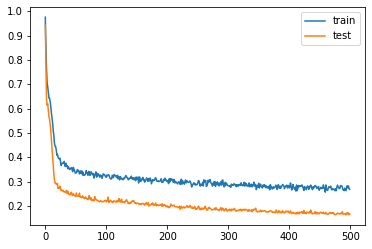

На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]
Да
Хорошо!


In [263]:
train_losses, test_losses = train(X_train, y_train, X_test, y_test, num_epoch=500) #Подберите количество эпох так, чтобы график loss сходился
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()
    
check_loss_decreased()
assert train_losses[-1] < 0.3 and test_losses[-1] < 0.3

### Вычислите accuracy получившейся модели на train и test

In [264]:
from sklearn.metrics import accuracy_score

model.eval()
train_pred_labels = model.forward(X_train).detach().numpy().argmax(axis=1)
test_pred_labels = model.forward(X_test).detach().numpy().argmax(axis=1)

train_acc = accuracy_score(train_pred_labels, y_train)
test_acc = accuracy_score(test_pred_labels, y_test)

assert train_acc > 0.9, "Если уж классифицировать звезды, которые уже видел, то не хуже, чем в 90% случаев"
assert test_acc > 0.9, "Новые звезды тоже надо классифицировать хотя бы в 90% случаев"

print("Train accuracy: {}\nTest accuracy: {}".format(train_acc, test_acc))

Train accuracy: 0.9570666666666666
Test accuracy: 0.9516


# Задание 3. Исправление ошибок в архитектуре

Только что вы обучили полносвязную нейронную сеть. Теперь вам предстоит проанализировать архитектуру нейронной сети ниже, исправить в ней ошибки и  обучить её с помощью той же функции train. Пример исправления ошибок есть в семинаре Григория Лелейтнера.

Будьте осторожнее и убедитесь, что перед запуском train вы вновь переопределили все необходимые внешние переменные (train обращается к глобальным переменным, в целом так делать не стоит, но сейчас это было оправдано, так как иначе нам пришлось бы передавать порядка 7-8 аргументов).

Чтобы у вас получилась такая же архитектура, как у нас, и ответы совпали, давайте определим некоторые правила, как исправлять ошибки:

1. Если вы видите лишний нелинейный слой, который стоит не на своем месте, просто удалите его. (не нужно добавлять новые слои, чтобы сделать постановку изначального слоя разумной. Удалять надо самый последний слой, который все портит. Для линейных слоев надо что-то исправить, а не удалить его)
2. Если у слоя нет активации, то добавьте ReLU или другую подходящую активацию
3. Если что-то не так с learning_rate, то поставьте 1e-2
4. Если что-то не так с параметрами, считайте первый параметр, который появляется, как верный (т.е. далее в сети должен использоваться он).
5. Ошибки могут быть и в полносвязных слоях. 
6. Любые другие проблемы решаются более менее однозначно, если же у вас есть серьезные сомнения, то напишите в беседу в телеграме и пинганите меня @runfme


Задача все та же - классификация небесных объектов на том же датасете. После исправления сети вам нужно обучить ее.

In [265]:
torch.manual_seed(42)   
np.random.seed(42)
# WRONG ARCH
model = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(6, 50),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(100, 200),
    nn.Softmax(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 3),
    nn.Dropout(p=0.5)
)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters[:-2], lr=1e-100)

TypeError: ignored

In [0]:
# RIGHT ARCH
torch.manual_seed(42)   
np.random.seed(42)
model = nn.Sequential(
    nn.Linear(len(feature_columns), 50),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(50, 200),
    nn.ReLU(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 3),
)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

### Обучите и протестируйте модель так же, как вы это сделали в задаче 2. Вычислите accuracy.

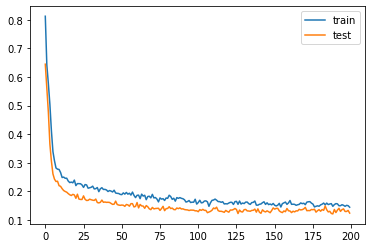

In [267]:
train_losses, test_losses = train(X_train, y_train, X_test, y_test, num_epoch=200)
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()

In [0]:
model.eval()
train_pred_labels = model.forward(X_train).detach().numpy().argmax(axis=1)
test_pred_labels = model.forward(X_test).detach().numpy().argmax(axis=1)

train_acc = accuracy_score(train_pred_labels, y_train)
test_acc = accuracy_score(test_pred_labels, y_test)


assert train_acc > 0.9, "Если уж классифицировать звезды, которые уже видел, то не хуже, чем в 90% случаев"
assert test_acc > 0.9, "Новые звезды тоже надо классифицировать хотя бы в 90% случаев"


# Задание 4. Stack layers

Давайте посмотрим, когда добавление перестает улучшать метрики. Увеличивайте блоков из слоев в сети, пока минимальный лосс на тестовом датасете за все время обучения не перестанет уменьшаться (20 эпох). 

Стоит помнить, что нельзя переиспользовать слои с предыдущих обучений, потому что они уже будут с подобранными весами.

**Чтобы получить воспроизводимость и идентичный нашему ответ, надо объявлять все слои в порядке, в котором они применяются внутри модели. Это важно, если вы будете собирать свою модель из частей. Перед объявлением этих слоев по порядку напишите**
> torch.manual_seed(42)   
> np.random.seed(42)

**Причем каждый раз, когда вы заново создаете модель, перезадавайте random seeds**

**Опитимизатор - Adam(lr=1e-2)**


In [0]:
# МОДЕЛЬ ДЛЯ ПРИМЕРА, НА САМОМ ДЕЛЕ ВАМ ПРИДЕТСЯ СОЗДАВАТЬ НОВУЮ МОДЕЛЬ ДЛЯ КАЖДОГО КОЛИЧЕСТВА БЛОКОВ
model = nn.Sequential(
    nn.Linear(len(feature_columns), 100),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    # Начало блока, который надо вставалять много раз
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    # Конец блока
    nn.Linear(100, 3)
    # Блока Softmax нет, поэтому нам нужно использовать лосс - CrossEntropyLoss
)

In [269]:
# Вы уже многое умеете, поэтому теперь код надо написать самому
# Идея - разделить модель на части.
# Вначале создать head часть как Sequential модель, потом в цикле создать Sequential модели, которые представляют
# из себя блоки, потом создать tail часть тоже как Sequential, а потом объединить их в одну Sequential модель 
# вот таким кодом: nn.Sequential(header, *blocks, footer)
# Важная идея тут состоит в том, что модели могут быть частями других моделей)

for num_of_blocks in range(1,15):
  # set seed
  torch.manual_seed(42)
  np.random.seed(42)

  head = nn.Sequential(
      nn.Linear(len(feature_columns), 100),
      nn.ReLU(),
      nn.Dropout(p=0.5))
  
  # make blocks
  block = nn.Sequential()
  for _ in range(num_of_blocks):
    block = nn.Sequential(
        block,
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.BatchNorm1d(100))

  tail = nn.Sequential(
      nn.Linear(100, 3))

  # set classes
  model = nn.Sequential(head, block, tail)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

  # train model
  train_losses, test_losses = train(X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    num_epoch=20)

  # model evaluate
  model.eval()
  train_pred_labels = model.forward(X_train).detach().numpy().argmax(axis=1)
  test_pred_labels = model.forward(X_test).detach().numpy().argmax(axis=1)

  train_acc = accuracy_score(train_pred_labels, y_train)
  test_acc = accuracy_score(test_pred_labels, y_test)
  
  print("Для %s блоков:\nmin test loss = %s, train_acc = %s, test_acc = %s" %\
        (num_of_blocks,
         round(min(test_losses).item(), 4),
         round(train_acc, 4),
         round(test_acc, 4)))

Для 1 блоков:
min test loss = 0.1729, train_acc = 0.9491, test_acc = 0.944
Для 2 блоков:
min test loss = 0.1731, train_acc = 0.9473, test_acc = 0.9412
Для 3 блоков:
min test loss = 0.1698, train_acc = 0.9492, test_acc = 0.942
Для 4 блоков:
min test loss = 0.1709, train_acc = 0.9481, test_acc = 0.9388
Для 5 блоков:
min test loss = 0.1693, train_acc = 0.9484, test_acc = 0.9432
Для 6 блоков:
min test loss = 0.1759, train_acc = 0.9459, test_acc = 0.9388
Для 7 блоков:
min test loss = 0.1768, train_acc = 0.9413, test_acc = 0.9312
Для 8 блоков:
min test loss = 0.1819, train_acc = 0.9461, test_acc = 0.9408
Для 9 блоков:
min test loss = 0.1861, train_acc = 0.9461, test_acc = 0.9428
Для 10 блоков:
min test loss = 0.1803, train_acc = 0.9452, test_acc = 0.9396
Для 11 блоков:
min test loss = 0.184, train_acc = 0.9437, test_acc = 0.9384
Для 12 блоков:
min test loss = 0.1873, train_acc = 0.9427, test_acc = 0.9392
Для 13 блоков:
min test loss = 0.1844, train_acc = 0.9429, test_acc = 0.9344
Для 14 блок

## Задание 5. Сделайте выводы 
Начиная с какого количества блоков минимальный лосс за время обучения увеличивается? Почему лишнее количество блоков не помогает модели? 

Минмальный лосс начинает увеличиваться примерно с 4-5 блоков. 
Лишнее кол-во блоков не помогает модели, так как она становится слишком сложной. Для того, чтобы сойтись к минимиму нужно все больше итераций оптимизатора.